# Data structures, and some use cases

## Node class

First we will start off with a simple node object, a node is a component of a graph and can have other nodes leading up to it, and nodes leading from it, but doesn't have to. Another optionality is to store data.

Here we introduce a simple node class, which just does this simplest function with methods get/set methods for the data, and the previous and next nodes.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import binom
import itertools
%matplotlib inline

class Node:

    def __init__(self, previous_nodes=None, next_nodes=None, data=None):
        if previous_nodes is not None:
            self.previous_nodes = previous_nodes
        else:
            self.previous_nodes = []
        if next_nodes is not None:
            self.next_nodes = next_nodes
        else:
            self.next_nodes = []
        self.data = data
        self.coo = ()

    def get_data(self):
        return self.data

    def set_data(self, data):
        self.data = data

    def get_previous_nodes(self):
        return self.previous_nodes

    def set_previous_nodes(self, nodes):
        self.previous_nodes.append(nodes)

    def get_next_nodes(self):
        return self.next_nodes

    def set_next_nodes(self, nodes):
        self.next_nodes.append(nodes)

Node objects present the basic building block of a tree which we intend to build, the code is pretty self-explanatory. One thing to note is that, technically the the next node of the current node, could be the node itself, this is a recurrent node, but for the purposes of this project, this will node be taken into consideration.

Next we present a binary tree, which is very similiar to the binomial tree which we will later on build, in the binomial tree pricing.


## Binary Tree

Binary tree, is usually recursively defined as a data structure where each parent node, has two child nodes, except for the last leaf nodes . Conventionally, nodes which do have subnodes in this data structure are called *interior nodes*, while the nodes in the last layer are called the *leaf nodes*.

Here we present the code for the binary tree

In [2]:
class BinaryTree:
    def __init__(self, depth=10):
        self.tree = []
        self.depth = depth

    def create_tree(self):
        for i in range(1, self.depth + 1):
            self.tree.append([Node(data=i)] * (1 << i))
        len_all_nodes = ([len(x) for x in self.tree])
        for i in range(1, len(len_all_nodes)):
            counter = 0
            for j in range(len_all_nodes[i]):
                if j % 2 == 0 and j > 0:
                    counter = counter + 1
                if i > 0:
                    self.tree[i - 1][counter].set_next_nodes(self.tree[i][j])

Note, here bitshifting once is equivalent to stating $2^i$. While usually one would go about creating a tree differently, we are interested in easier traversal of the full tree structure, thus we opted not to set each of the interior nodes recursively by simply appending two nodes, then doing the same for the next node in the next layer. 

This would make things like computing the mean along a certain axis fairly more complex. Binary trees in their original form would be more suitable for things where there is a decision boundary that acts a sentinel for traversing the path.

You can access the data at each layer, by simply calling the nodes *get_data()* method, same goes for setting the data. By default the depth of the tree is set to 10, one could go for larger trees, in that case, the whole structure could be converted to numpy arrays in order to make the code work quicker, but in this project, we will not use a larger depth than 10.

## Binomial Tree

Binomial tree is a fairly similiar data structure to the binary tree, the key difference lies in it's the definitinion. Above we stated the definition for the binary tree, we should alse introduce the concept of left and right nodes, which are each of the subnodes of the inner nodes up to the leafs, furthermore, with distinct branches.

This simply means that, except for the leafs, each node has a left and right node, that are not connected. For the binomial tree, the recursive definition states that only the top-most and the bottom-most node have two distinct subnodes, while for all the other inner nodes, one of the nodes is distinct, while the other shares a connection with a previously defined node.

Below, we present the code to define a binary tree, same as before we did not create the tree recursively in order to make the data manipulation easier. Also each **Node** object is instantiated with dummy data, so the objects are not referencing the same object in memory. 

In [3]:
class BinomialTree(BinaryTree):

    def __init__(self, depth=10):
        super().__init__(depth)
        self.flat_tree = []
        self.print_coo = []
        self.sorted_coo = []
        self.create_tree()
        self.set_plot_coo()
        self.row_coo = []
        self.col_coo = []
        self.y_coo_sorted=[]

    def create_tree(self):
        self.tree.append([Node(data=0)])
        for s in range(1, self.depth):
            self.tree.append([])
            for j in range(s + 1):
                self.tree[s].append(Node(data=s))
        len_all_nodes = ([len(x) for x in self.tree])
        for k in range(len(len_all_nodes) - 1):
            for m in range(len_all_nodes[k]):
                self.tree[k][m].set_next_nodes(self.tree[k + 1][m])
                self.tree[k][m].set_next_nodes(self.tree[k + 1][m + 1])
        self.flat_tree = itertools.chain(*self.tree)
        self.flat_tree = list(self.flat_tree)

    def set_tree_node(self, data, i, j):
        self.tree[i][j].set_data(data)

    def get_tree_node(self, i, j):
        return self.tree[i][j]

    def set_plot_coo(self):
        number_of_rows = self.depth * 2 - 1
        for i in range(number_of_rows):
            count = 0
            bound = 0
            for j in range(self.depth):
                x = i if (number_of_rows - self.depth - bound) <= i <= (number_of_rows - self.depth + bound) else " "
                bound += 1
                if x != " ":
                    x = (i + j + self.depth) % 2
                    if x == 1:
                        self.print_coo.append((j, i))
                        count += 1
                if x != 1:
                    x = " "

    def set_up(self):
        self.row_coo = [coo[0] for coo in self.print_coo]
        self.col_coo = [coo[1] for coo in self.print_coo]
        self.y_coo_sorted = np.sort(np.array(self.col_coo))
        temp_row_coo = []

        for x in self.row_coo:
            temp_row_coo.append(x)

        sort_for_mesh = sorted(zip(temp_row_coo, self.y_coo_sorted))
        self.sorted_coo = sort_for_mesh
        for node, coo in zip(self.flat_tree, self.sorted_coo):
            node.coo = coo

    def plot_tree(self):
        self.set_up()
        plt.plot(np.array(self.row_coo), self.y_coo_sorted, "ob")
        plt.yticks(np.arange(self.depth * 2 - 1))
        plt.xticks(np.arange(self.depth))

        temp_row_coo = []

        for x in self.row_coo:
            temp_row_coo.append(x)

        sort_for_plot = sorted(zip(temp_row_coo, self.y_coo_sorted))
        self.sorted_coo = sort_for_plot
        for i, j in zip(sort_for_plot, self.flat_tree):
            plt.annotate(j.get_data(), (i[0] - .05, i[1] + .25))

        for x in range(len(self.tree) - 1):
            for y in range(x + 1):
                alpha1 = binom(x, y) / 2**x
                alpha2 = binom(x, y + 1) / 2**x
                plt.plot([self.tree[x][y].coo[0], self.tree[x + 1][y].coo[0]],
                         [self.tree[x][y].coo[1], self.tree[x + 1][y].coo[1]], "k-")
                plt.plot([self.tree[x][y].coo[0], self.tree[x + 1][y + 1].coo[0]],
                         [self.tree[x][y].coo[1], self.tree[x + 1][y + 1].coo[1]], "k-")

        plt.show()

    def print_tree(self):
        self.set_up()
        mesh = np.full((len(self.tree), 2 * len(self.tree) - 1), " ")
        for xy, z in zip(self.sorted_coo, self.flat_tree):
            mesh[xy[0]][xy[1]] = z.get_data()

        mesh = mesh.T
        print(mesh)

This class is mostly built only to display the tree that will be calculated, there is rarely any usecases where a difference of two trees is needed, but this could be easily done by overloading the subtract operator, with careful checking of the suitable length of the trees. Here the coordinate option to display and print was choosen, simply because it makes debugging horrifying, and coordinates are far more readable.

Also for debugging purposes I have seperated the parts where the notes, and the tree structure are initialized, set_up() doesn't need to be called unless for displaying/printing purposes. Otherwise all the nodes are accessible through the self.tree array. Also, if needed a return statement to the print_tree could be added to the print_tree method, and then converted to sparse, if you need to do operations on it.

Usually these trees are, like the binary trees, suboptimal in the context of calculations, since they grow fairly large in a short amount of steps. This is the why depth is set to 10 by default.

Also I have added set and get methods for nodes, if a certain operation should be performed on a particular node.

## Notes on the binary and binomial tree

Here I will show, how these trees are related, and use that opportunity to provide a minimal use case example. First, consider the binomial tree, each of the nodes, like the binary tree has two possible connections. Except that only the first and the last are the only ones that have unique connections (meaning only one path possible to get to the node). The tree with ones just shows how the coordinates are obtained.

[<__main__.Node object at 0x000001C354453C10>, <__main__.Node object at 0x000001C3451843D0>]


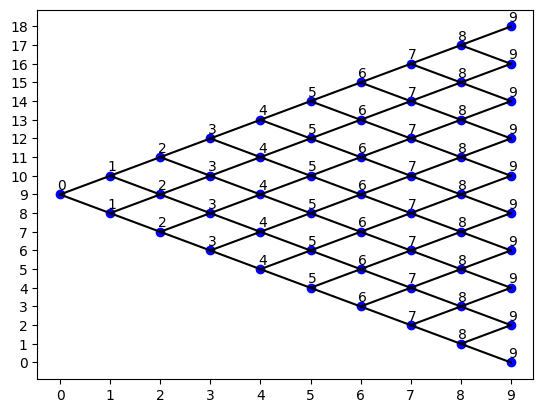

[[' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' '9']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' '8' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' '7' ' ' '9']
 [' ' ' ' ' ' ' ' ' ' ' ' '6' ' ' '8' ' ']
 [' ' ' ' ' ' ' ' ' ' '5' ' ' '7' ' ' '9']
 [' ' ' ' ' ' ' ' '4' ' ' '6' ' ' '8' ' ']
 [' ' ' ' ' ' '3' ' ' '5' ' ' '7' ' ' '9']
 [' ' ' ' '2' ' ' '4' ' ' '6' ' ' '8' ' ']
 [' ' '1' ' ' '3' ' ' '5' ' ' '7' ' ' '9']
 ['0' ' ' '2' ' ' '4' ' ' '6' ' ' '8' ' ']
 [' ' '1' ' ' '3' ' ' '5' ' ' '7' ' ' '9']
 [' ' ' ' '2' ' ' '4' ' ' '6' ' ' '8' ' ']
 [' ' ' ' ' ' '3' ' ' '5' ' ' '7' ' ' '9']
 [' ' ' ' ' ' ' ' '4' ' ' '6' ' ' '8' ' ']
 [' ' ' ' ' ' ' ' ' ' '5' ' ' '7' ' ' '9']
 [' ' ' ' ' ' ' ' ' ' ' ' '6' ' ' '8' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' '7' ' ' '9']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' '8' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' '9']]


In [4]:
a = BinomialTree()
b = a.get_tree_node(1, 0)
print(b.get_next_nodes())
a.plot_tree();
a.print_tree()

Consider that you are currently at node (0,0), there is only one way to get to the node at (1,0), and only one way to get to the node at (1,1). Now consider taking a step to the layer (1, ), now there is one possible way to get to the node at (2,0), then there are 2 ways to get to the node (2, 1) through nodes (1, 0) and (1, 1), and one way to get to the node at (2,2). The total number of paths you could take to get to any node at layer **i** is $2^i$, which is exactly the number nodes that can be found at layer **i** in the binary data structure. The total path you can take, to get to a certain node, turns out to be $nCr$, where $nCr$ is the choose function, since we are sampling a smaller subset, where the order doesnt matter from a larger space.

In fact, this can be a way to obtain the PMF for a random variable with a binomial distribution. You can get the paths to any node by using scipy's binom function, as shown below.

In [5]:
n = 6
possible_paths = np.array([binom(n, x) for x in range(n + 1)], dtype=int)
np.sum(possible_paths)

64

Since, as stated before the total number of path you can take to get at any node is $n^2$, to get the probability of getting to a certain node, you can simply devide the number of paths by that number

In [6]:
bin_distribution = possible_paths / 2**n
bin_distribution

array([0.015625, 0.09375 , 0.234375, 0.3125  , 0.234375, 0.09375 ,
       0.015625])

If you plot it, it may look familiar:

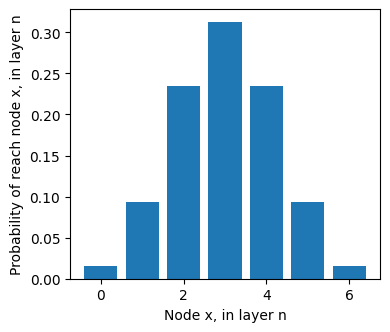

In [8]:
plt.bar(np.arange(n + 1), bin_distribution)
plt.ylabel("Probability of reach node x, in layer n")
plt.xlabel("Node x, in layer n");
plt.rcParams['figure.figsize'] = [4, 3.5]

As the number of layers approaches infinity, the binomial distribution as stated above, converges to the normal distribution, which is the basis on which the binomial tree pricing works. 